In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Step 1: Load the data
tesla_data = pd.read_csv('Clean_data/Cleaned_Tesla_Close.csv', parse_dates=['Date'], index_col='Date')
sp500_data = pd.read_csv('Clean_data/Cleaned_SP500_Close.csv', parse_dates=['Date'], index_col='Date')
ixic_data = pd.read_csv('Clean_data/Cleaned_IXIC_Close.csv', parse_dates=['Date'], index_col='Date')

# Merge datasets on 'Date'
merged_data = tesla_data.merge(sp500_data, left_index=True, right_index=True, suffixes=('', '_sp500'))
merged_data = merged_data.merge(ixic_data, left_index=True, right_index=True, suffixes=('', '_ixic'))

# Step 2: Preprocess the data
data = merged_data[['Close', 'Close_sp500', 'Close_ixic']]
data = data.fillna(method='ffill').fillna(method='bfill')

# Scale the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Prepare the dataset for LSTM
def create_dataset(dataset, time_step=60):
    X, y = [], []
    for i in range(time_step, len(dataset)):
        X.append(dataset[i - time_step:i])
        y.append(dataset[i, 0])
    return np.array(X), np.array(y)

time_step = 60
X, y = create_dataset(scaled_data, time_step)

# Split data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Function to reset random seeds
def reset_random_seeds(seed=11):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

# Reset seeds before any computation
reset_random_seeds(seed=42)

# Step 3: Build and train the LSTM model
model = Sequential([
    LSTM(71, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.21),
    LSTM(71),
    Dropout(0.21),
    Dense(1)
])
optimizer = Adam(learning_rate=0.0018)
model.compile(optimizer=optimizer, loss='mean_squared_error')
model.fit(X_train, y_train, epochs=163, batch_size=16, verbose=1)

# Step 4: Make predictions on the test set
test_predictions = model.predict(X_test)

# Reverse scaling for test predictions
test_predictions_rescaled = scaler.inverse_transform(
    np.hstack([test_predictions, X_test[:, -1, 1:]])
)[:, 0]
y_test_rescaled = scaler.inverse_transform(
    np.hstack([y_test.reshape(-1, 1), X_test[:, -1, 1:]])
)[:, 0]

# Step 5: Calculate performance metrics
test_rmse = np.sqrt(mean_squared_error(y_test_rescaled, test_predictions_rescaled))
test_mape = mean_absolute_percentage_error(y_test_rescaled, test_predictions_rescaled)
test_mae = mean_absolute_error(y_test_rescaled, test_predictions_rescaled)

print(f'Test RMSE: {test_rmse:.2f}')
print(f'Test MAPE: {test_mape:.2%}')
print(f'Test MAE: {test_mae:.2f}')




Epoch 1/163


C:\Users\Admin\AppData\Local\Temp\ipykernel_16488\1763667979.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill').fillna(method='bfill')
D:\Python\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0265
Epoch 2/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0036
Epoch 3/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0048
Epoch 4/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0029
Epoch 5/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0045
Epoch 6/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0033
Epoch 7/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0026
Epoch 8/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0023
Epoch 9/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0025
Epoch 10/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0028
Epoch 11/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020
Epoch 12/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0022
Epoch 13/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019
Epoch 14/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0024
Epoch 15/163
71/71 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0018
E

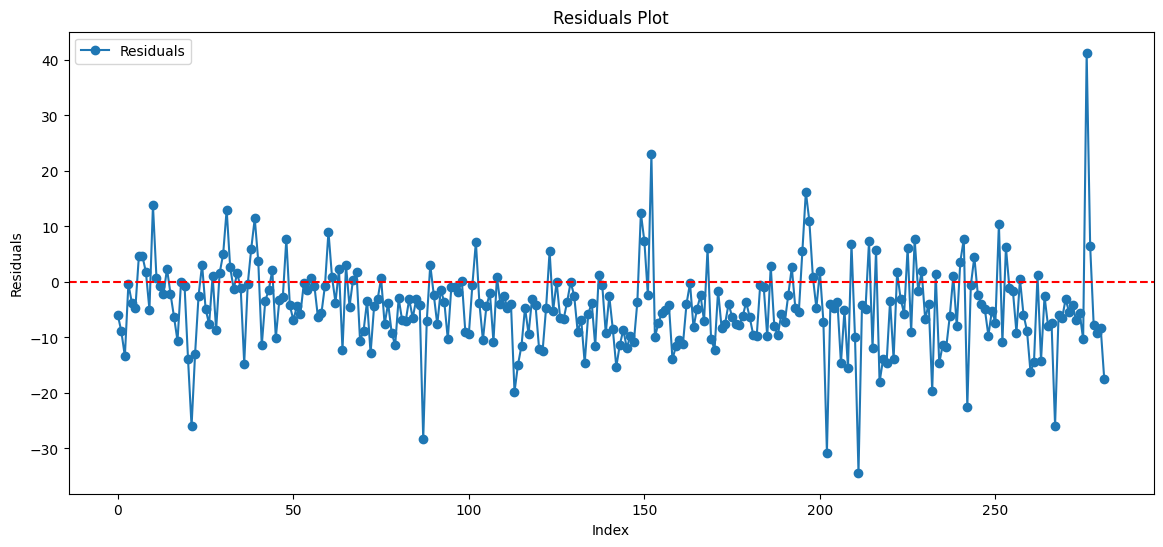

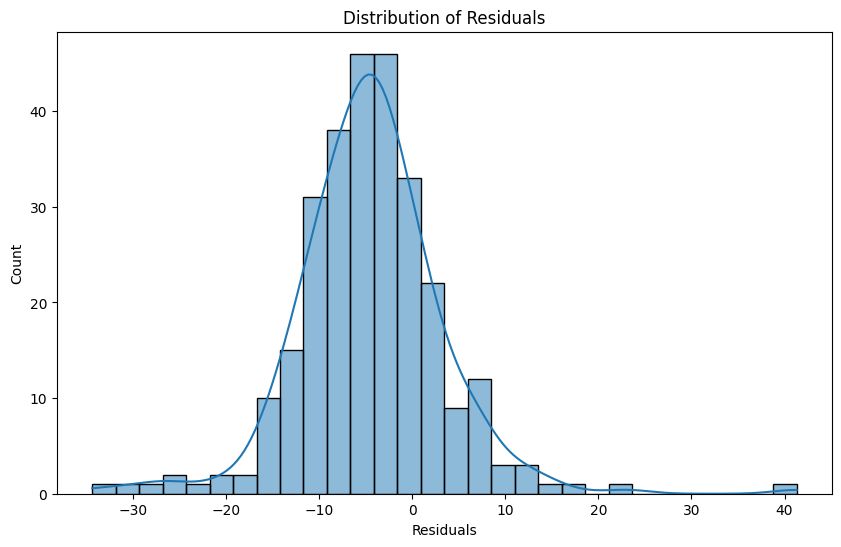

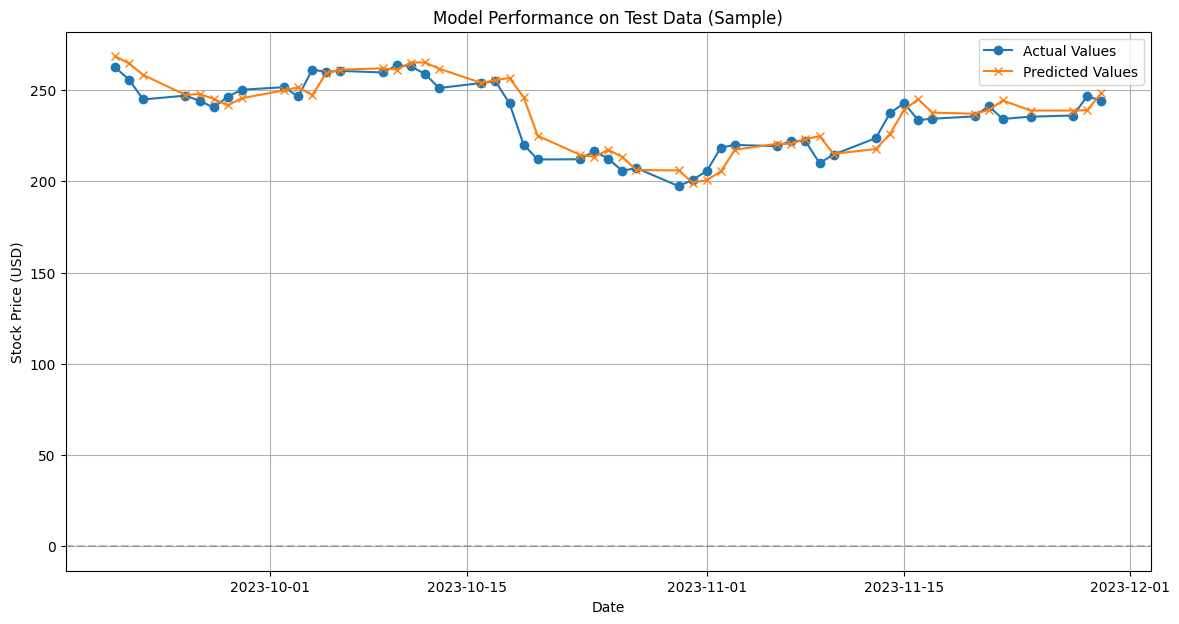

Sample RMSE: 7.66
Sample MAPE: 2.44%
Sample MAE: 5.66


In [18]:
# Step 6: Analyze residuals
residuals = y_test_rescaled - test_predictions_rescaled

# Plot residuals
plt.figure(figsize=(14, 6))
plt.plot(residuals, marker='o', linestyle='-', label='Residuals')
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Index')
plt.ylabel('Residuals')
plt.legend()
plt.show()

# Histogram of residuals
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.xlabel('Residuals')
plt.show()

# Step 7: Plot sample predictions
sample_size = 50
sample_dates = merged_data.index[train_size + time_step:train_size + time_step + sample_size]
y_test_sample = y_test_rescaled[:sample_size]
predictions_sample = test_predictions_rescaled[:sample_size]

plt.figure(figsize=(14, 7))
plt.plot(sample_dates, y_test_sample, label='Actual Values', marker='o')
plt.plot(sample_dates, predictions_sample, label='Predicted Values', marker='x')
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.title('Model Performance on Test Data (Sample)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.legend()
plt.grid()
plt.show()

# Calculate sample metrics
sample_rmse = np.sqrt(mean_squared_error(y_test_sample, predictions_sample))
sample_mape = mean_absolute_percentage_error(y_test_sample, predictions_sample)
sample_mae = mean_absolute_error(y_test_sample, predictions_sample)

print(f"Sample RMSE: {sample_rmse:.2f}")
print(f"Sample MAPE: {sample_mape:.2%}")
print(f"Sample MAE: {sample_mae:.2f}")

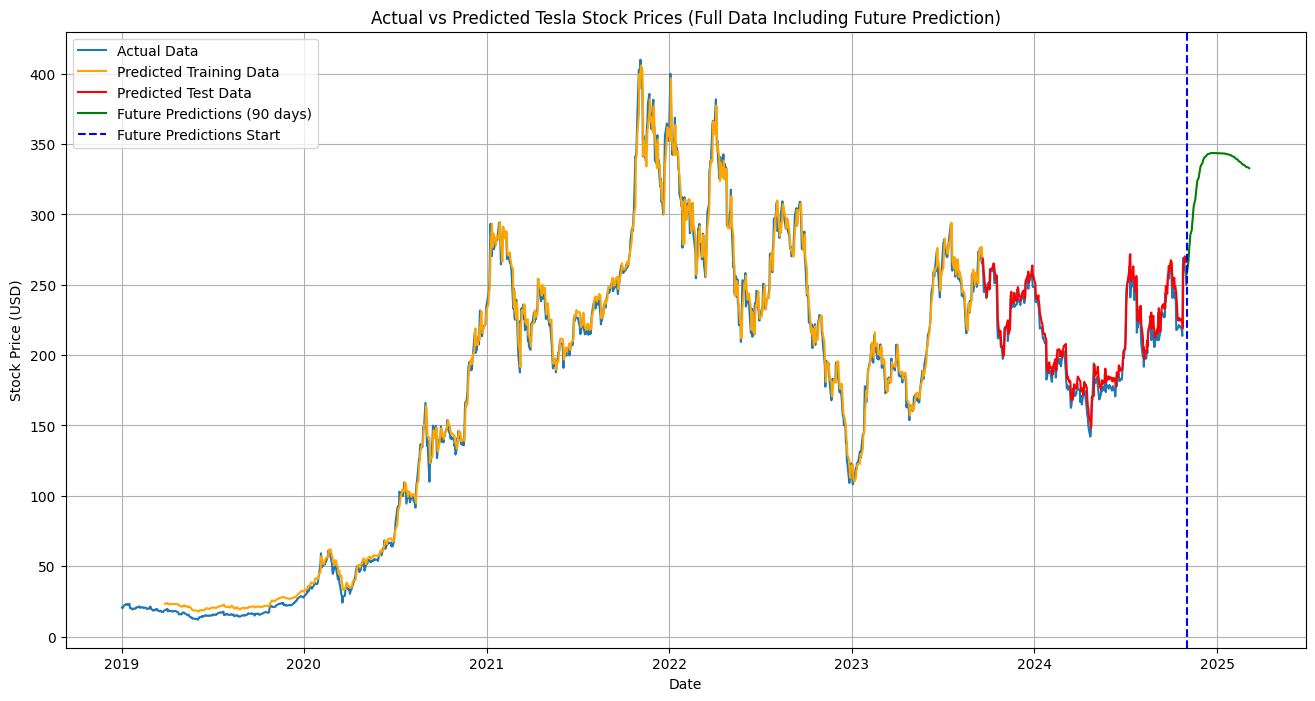

In [19]:
# Step 6: Predict future data (next 90 days)
# Ensure last_60_days is valid and correctly shaped
last_60_days = scaled_data[-time_step:]
assert last_60_days.shape == (time_step, scaled_data.shape[1]), "Error: last_60_days shape mismatch."

# Reshape input sequence for prediction
input_seq = last_60_days.reshape(1, last_60_days.shape[0], last_60_days.shape[1])

future_predictions = []

# Predict next 90 days
for day in range(90):
    # Make prediction
    pred = model.predict(input_seq, verbose=0)
    future_predictions.append(pred[0, 0])  # Append only the 'Close' prediction
    
    # Update input sequence
    next_step = np.zeros_like(input_seq)
    next_step[:, :-1, :] = input_seq[:, 1:, :]  # Shift sequence one step
    next_step[:, -1, 0] = pred  # Update 'Close' prediction
    next_step[:, -1, 1:] = input_seq[:, -1, 1:]  # Retain other features (sp500, ixic)
    input_seq = next_step

# Reverse scaling for future predictions
future_predictions_rescaled = scaler.inverse_transform(
    np.hstack([np.array(future_predictions).reshape(-1, 1), np.zeros((90, 2))])
)[:, 0]

# Ensure predictions are valid
assert len(future_predictions_rescaled) == 90, "Error: Incorrect number of future predictions."

# Step 7: Plot predictions
plt.figure(figsize=(16, 8))

# Plot actual data
plt.plot(merged_data.index, merged_data['Close'], label='Actual Data')

# Predict on training data and reverse scale
train_predictions = model.predict(X_train, verbose=0)
train_predictions_rescaled = scaler.inverse_transform(
    np.hstack([train_predictions, X_train[:, -1, 1:]])
)[:, 0]
plt.plot(merged_data.index[time_step:train_size + time_step], train_predictions_rescaled, 
         label='Predicted Training Data', color='orange')

# Plot test predictions
x_test_dates = merged_data.index[train_size + time_step:train_size + time_step + len(test_predictions_rescaled)]
plt.plot(x_test_dates, test_predictions_rescaled, label='Predicted Test Data', color='red')

# Plot future predictions
future_dates = pd.date_range(start=merged_data.index[-1], periods=91, freq='B')[1:]
plt.plot(future_dates, future_predictions_rescaled, label='Future Predictions (90 days)', color='green')

# Add labels and legend
plt.title('Actual vs Predicted Tesla Stock Prices (Full Data Including Future Prediction)')
plt.xlabel('Date')
plt.ylabel('Stock Price (USD)')
plt.axvline(x=future_dates[0], color='blue', linestyle='--', label='Future Predictions Start')
plt.legend()
plt.grid()
plt.show()
